### Module 4A - Genetic Algorithms (for sintering process simulation)

Written for AIFS.   
Copyright 2023 Tarek Zohdi, Carla Becker. All rights reserved.

This is the code for sintering simulation. You can see how temperature and densification parameter change during the sintering process. 

In [20]:
############################################### Import Packages ##########################################
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from matplotlib import rc

############################################### Givens ########################################## 
J3 = 9151166.644001838
D0 = 0.7390757725102297

# Material variables (what someone would measure in the lab)
rho0 = 2350     # material density in reference configuration, [kg/m3], 1x1
kappa = 85e9    # dense material bulk modulus, [Pa], 1x1
mu = 22e9       # dense material shear modulus, [Pa], 1x1
beta = 2e-5     # coefficient of thermal expansion, [1/K], 1x1
C = 850         # specific heat capacity, [J/K/kg], 1x1
sigmac0 = 1e5   # dense material electrical conductivity, [S/m], 3x3
sigmad0 = 1.2e6 # reference densification threshold, [Pa], 1x1
sigmay0 = 38e6  # reference yield strength, [Pa], 1x1
a = 0.8         # Joule heating absorption coefficient, [unitless], 1x1

# Elastic Strain
c1 = kappa + 4/3*mu # modulus for elasticty tensor, [Pa], 1x1
c2 = kappa - 2/3*mu # modulus for elasticty tensor, [Pa], 1x1

EE0 = np.array([[c1, c2, c2, 0,  0,  0],\
                [c2, c1, c2, 0,  0,  0],\
                [c2, c2, c1, 0,  0,  0],\
                [0,  0,  0,  mu, 0,  0],\
                [0,  0,  0,  0,  mu, 0],\
                [0,  0,  0,  0,  0,  mu]]) # compliance/elasticity tensor, [Pa], 6x6

# Sintering settings (what someone would set on equipment)  
theta0 = 300 # initial temperature, [K], 1x1 
divq0 = -30  # divergence of heat flux, [W/m2], 3x1
J = np.array([0, 0, J3]) # current density, [A/m2] , 3x1

# "Fudge" Factors
A1 = 2.5e-4 # densification rate parameter, [unitless]
A2 = 1.5    # plasticity rate parameter, [unitless]
P1 = 1e-3   # elasticity thermal parameter, [unitless], 1x1
P2 = 1e-3   # conductivity thermal parameter, [unitless], 1x1
P3 = 1e-3   # densification thermal parameter, [unitless], 1x1
P4 = 1e-3   # yield strength thermal parameter, [unitless], 1x1
d0 = D0     # initial densification parameter, [unitless], 1x1

# Kinematic variables
dt = 1e-4               # time step, [s], 1x1
T = 1.0                 # simulation time, [s], 1x1
nt = int(T/dt)          # of time points, [unitless], 1x1
t = np.linspace(0,T,nt) # time points, [s], 1xnt

## Helper functions
# For converting between standard and voight notation FOR STRAINS

toptri = np.array([[0, 1, 1],\
                   [0, 0, 1],\
                   [0, 0, 0]]) # for obtaining upper right triangle of 3x3 matrix
mat69 = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],\
                  [0, 0, 0, 0, 1, 0, 0, 0, 0],\
                  [0, 0, 0, 0, 0, 0, 0, 0, 1],\
                  [0, 1, 0, 0, 0, 0, 0, 0, 0],\
                  [0, 0, 0, 0, 0, 1, 0, 0, 0],\
                  [0, 0, 1, 0, 0, 0, 0, 0, 0]])
mat96 = np.array([[1, 0, 0, 0,   0,   0],\
                  [0, 0, 0, 1/2, 0,   0],\
                  [0, 0, 0, 0,   0,   1/2],\
                  [0, 0, 0, 1/2, 0,   0],\
                  [0, 1, 0, 0,   0,   0],\
                  [0, 0, 0, 0,   1/2, 0],\
                  [0, 0, 0, 0,   0,   1/2],\
                  [0, 0, 0, 0,   1/2, 0],\
                  [0, 0, 1, 0,   0,   0]])
half_voight = np.array([[1], [1], [1], [1/2], [1/2], [1/2]])

def voight(mat33):
    mat91 = np.reshape(np.multiply(mat33, 2*toptri+np.identity(3)), [9,1]) # element-wise multiplication
    mat61 = np.matmul(mat69, mat91)
    return mat61

def ivoight(mat61):
    mat91 = np.matmul(mat96, mat61)
    mat33 = mat91.reshape(3,3)
    return mat33

def frob_norm(mat33):
    hadamard = np.multiply(mat33, mat33)
    frob_norm = np.sqrt(hadamard.sum())
    return frob_norm

## Initialize deliverable variables
pressure = np.zeros(nt)        # hydrostatic pressure, [Pa], 1xnt
frobenius = np.zeros(nt)       # Frobenius norm of the deviatoric stress, [Pa], 1xnt
densification = np.ones(nt)*d0 # densification parameter, [unitless], 1xnt
norm2_plastic = np.zeros(nt)   # 2-norm of the plastic strain, [unitless], 1xnt

## Other storage variables for time stepping
# Note: No deformation in first time step -- initial strain is zero
sigma = np.zeros([3,3])
Ep =  np.zeros([3,3])

temperature = np.ones(nt)*theta0 # current temperature, [K], 1xnt
thetadot = np.zeros(nt)          # time rate of change of temp, [K/s], 1xnt

## Time Stepping the Governing Equation for Rate of Thermal Energy Storage
for n in range(nt-1):

    # Read-in values from previous time step
    dn = densification[n]
    thetan = temperature[n]
    thetadotlast = thetadot[n]
    Eplast = Ep
    siglast = sigma

    # Effects from Thermal Softening
    softn = np.exp(-(thetan - theta0)/theta0) # thermal softening parameter, [unitless], 1x1
    EEn = EE0*(1-dn)*softn**P1                # effective elasticity tensor, [Pa], 6X6
    sigmacn = sigmac0*softn**P2*(1-dn)        # effective electrical conductivity, [S/m], 3x3
    sigmadn = sigmad0*softn**P3               # densification stress threshold, [Pa], 1x1
    sigmayn = sigmay0*softn**P4               # densification stress threshold, [Pa], 1x1

    # Stress Analysis
    Bn = np.array([[0, 0, 0],\
                   [0, 0, 0],\
                   [0, 0, -0.15*(n+1)*dt]])           # du/dX as a function of time, [unitless], 3x3
    Fn = np.identity(3) + Bn                          # deformation gradient as a function of time, [unitless], 3x3
    Jacn = np.linalg.det(Fn)                          # Jacobian, [unitless], 1x1
    E33n = 1/2*(np.matmul(Fn.T, Fn) - np.identity(3)) # Green-Lagrange strain, [unitless], 3x3
    E61n = voight(E33n)                               # Green-Lagrange strain, [unitless], 6x1
    
    # Use previous time step to calculate plastic strain
    sphsiglast = 1/3*np.trace(siglast)*np.identity(3) # volumetric (or spherical) stress, [Pa], 3x3
    devsiglast = siglast - sphsiglast                 # deviatoric stress, [Pa], 3x3
    p = -1/3*np.trace(siglast)                        # hydrostatic pressure, [Pa], 1xnt

    if -p<=0 and abs(p)>sigmadn and dn>0:
        ddotn = -A1*(abs(p)/sigmadn - 1)
    elif dn<0:
        dn = 0
        ddotn = 0
    else:
        ddotn = 0
    dnew = dn + ddotn*dt

    # Plastic Strain
    frobn = frob_norm(devsiglast)
    if frobn > sigmayn:
        lambda_dotn = A2*(frobn/sigmayn - 1)  # rate parameter for evolution of plastic strain, [unitless], 1x1
        epdotn = lambda_dotn*devsiglast/frobn # Eulerian plastic strain rate, [unitless], 3x3
    else:
        epdotn = np.zeros([3,3])

    Epdotn = Jacn * np.matmul(np.linalg.inv(Fn), np.matmul(epdotn, np.linalg.inv(Fn.T))) # Lagrangian plastic strain rate, [unitless], 3x3
    Ep33n = Eplast + Epdotn*dt
    Ep61n = voight(Ep33n)                                                                # plastic strain, [unitless], 6x1

    # Thermal Strain
    Et33n = beta*(thetan - theta0)*np.identity(3) # thermal strain, [unitless], 3x3
    Et61n = voight(Et33n)                         # thermal strain, [unitless], 6x1

    # Second-Piola Kirchoff stress
    # Combine the Green-Lagrange, thermal, and plastic Strains to find the elastic strain
    Ee61n = E61n - Ep61n - Et61n # elastic strain, [unitless], 6x1
    S61n = np.matmul(EEn, Ee61n) # Second-Piola Kirchoff stress, [Pa], 6x1
    S33n = ivoight(S61n)         # Second-Piola Kirchoff stress, [Pa], 3x3

    # Calculate the Cauchy stress and hydrostatic pressure  for the current time step
    sig33n = 1/Jacn * np.matmul(Fn, np.matmul(S33n, Fn.T)) # Cauchy stress, [Pa], 3x3

    # Electrical analysis
    Hn = a/sigmacn * J3 * J3 # Joule heating power, [W/m3], 1x1

    # Governing Equation
    half_Ee61 = np.multiply(Ee61n, half_voight) # adjust for extra factors of 2 in Voight multiplication
    W = 1/2 * float(np.dot(half_Ee61.T, np.matmul(EE0, Ee61n))) # stored elastic energy

    thetadotn_num = np.multiply(S33n, Epdotn).sum() + ddotn*softn**P1*W - divq0 + Jacn*Hn
    thetadotn_den = rho0*C - beta*np.trace(S33n) - (1-dn)/theta0*P1*softn**P1*W
    thetadotn = thetadotn_num/thetadotn_den
    thetanew = thetan + thetadotn*dt

    # Update deliverable values and measures of error
    pressure[n+1] = p
    densification[n+1] = dnew
    temperature[n+1] = thetanew
    thetadot[n+1] = thetadotn
    frobenius[n+1] = frobn
    sigma = sig33n
    Ep= Ep33n
    norm2_plastic[n+1] = np.linalg.norm(Ep33n)

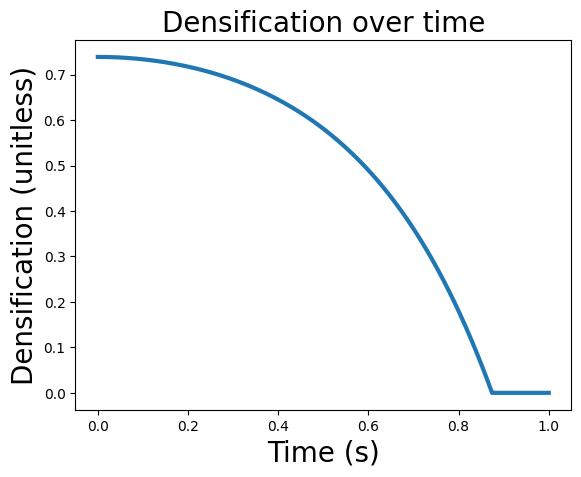

In [21]:
############################################### Simulation Results ########################################## 
# Plot the densification over time
# Hint: The densification should decrease exponentially before densification occurs at t~0.8 s
fig1 = plt.figure(1)
ax3 = plt.gca()
ax3.plot(t, densification, linewidth=3)
ax3.set_xlabel('Time (s)', fontsize=20)
ax3.set_ylabel('Densification (unitless)', fontsize=20)
ax3.set_title('Densification over time', fontsize=20)
plt.show()


Text(0.5, 1.0, 'Temperature over time')

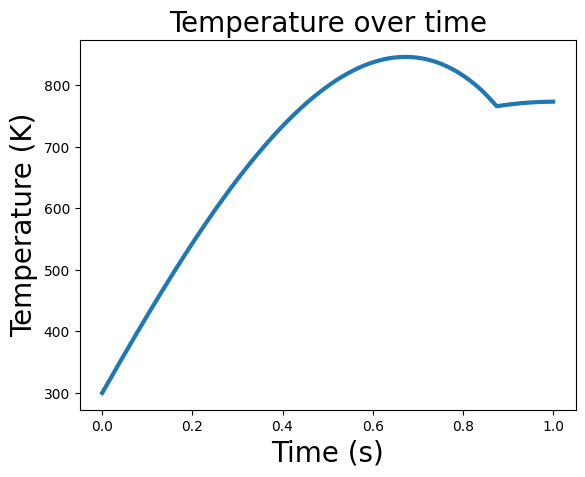

In [22]:
# Plot the temperature over time
# Hint: The temperature should reach a maximum at t=0.65 s with a value of theta~800 K
fig2 = plt.figure(2)
ax4 = plt.gca()
ax4.plot(t, temperature, linewidth=3)
ax4.set_xlabel('Time (s)', fontsize=20)
ax4.set_ylabel('Temperature (K)', fontsize=20)
ax4.set_title('Temperature over time', fontsize=20)